# Denoising Dirty Documents

This is a project to determine how well we can use autoencoders to create a denoising algorithm for images. The final output will be submitted to MLEBench, and will then be scored.

We will be using autoencoders in Keras. This is because autoencoders specifically excel at denoising data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import keras
import sklearn
import cv2
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from sklearn.model_selection import train_test_split
from pathlib import Path
import zipfile

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


Using pathlib, we can define the filepaths as below:

In [2]:

input_path = Path('/kaggle/input/denoising-dirty-documents/')

train = input_path / 'train.zip'
sample_submission = input_path / 'sampleSubmission.csv.zip'
train_cleaned = input_path / 'train_cleaned.zip'
test = input_path / 'test.zip'


In [3]:
def create_working_dir(input_path):
    
    working_dir = Path('/kaggle/working')
    working_dir.mkdir(parents = True, exist_ok = True)
    
    for zip_file in [train, sample_submission, train_cleaned, test]:
        with zipfile.ZipFile(input_path/zip_file, 'r') as zip_ref:
            zip_ref.extractall(working_dir)

    return working_dir

# Preprocessing Data

Having created a working directory for our data, we will now pass it through multiple functions to process it and prepare it for denoising.

First, we create a helper function that processes each image, by converting it to greyscale and resizing it.

In [4]:
def process_image(img_path):
        
    img = cv2.imread(img_path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

Next, a function takes all the different images and applies the helper function to them.

In [5]:
def preprocess_data(working_dir):
    train_images = []
    train_cleaned_images = []
    test_images = []
    
    print(f"Processing images from {working_dir}")
    
    for img_path in sorted((working_dir / 'train').glob('*')):
        train_images.append(process_image(str(img_path)))
    print(f"Processed {len(train_images)} training images")
    
    for img_path in sorted((working_dir / 'train_cleaned').glob('*')):
        train_cleaned_images.append(process_image(str(img_path)))
    print(f"Processed {len(train_cleaned_images)} cleaned training images")
    
    for img_path in sorted((working_dir / 'test').glob('*')):
        test_images.append(process_image(str(img_path)))
    print(f"Processed {len(test_images)} test images")
    
    X_train = np.array(train_images)
    Y_train = np.array(train_cleaned_images)
    X_test = np.array(test_images)
    
    if len(X_train) > 0 and len(Y_train) > 0:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)
    else:
        raise ValueError("No images were processed. Check your image files and processing function.")
    
    return X_train, X_val, Y_train, Y_val, X_test, [f.name for f in sorted((working_dir / 'train').glob('*'))]


Processing images from /kaggle/working
Processed 144 training images
Processed 144 cleaned training images
Processed 72 test images


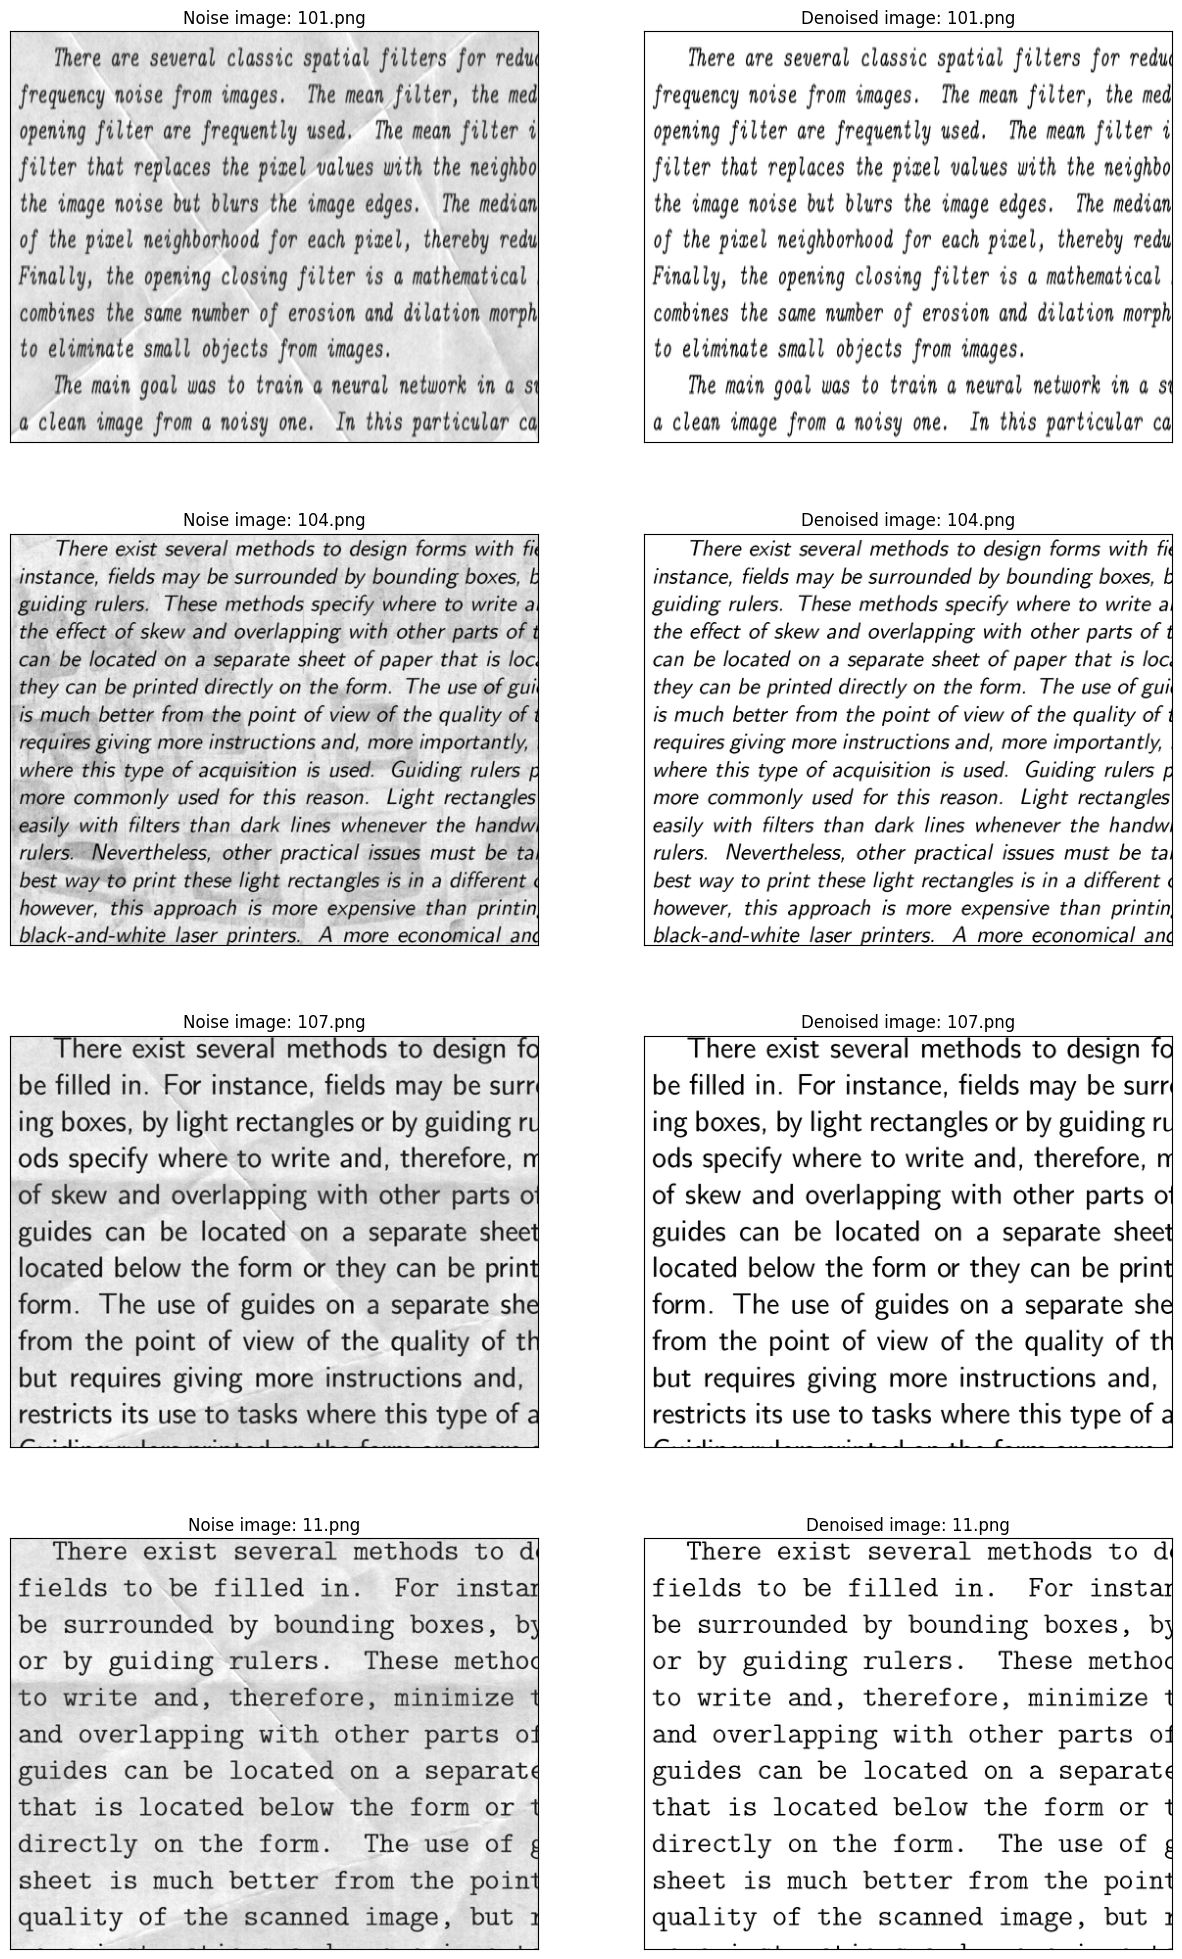

In [6]:
working_dir = create_working_dir(input_path)
X_train, X_val, Y_train, Y_val, X_test, train_img = preprocess_data(working_dir)


plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_train[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()